# Chapter 10. Attention Mechanisms

- 시신경망의 연구에서 착안
  - 시신경은 인간의 두뇌가 처리할 수 있는것을 뛰어넘는 정보를 받아들임
  - 의식적인 집중을 통해 방대한 시각 정보 중 의미있는 부분에 대한 선택적인 처리를 함
  - 인지 신경과학 분야에서 19세기부터 연구
  - Nadaraya-Watson kernel regression 연구에서 ML에 이러한 Attention mechanism을 도입

- 주요 내용
  - Attention functions에 대한 소개 (특히 Bahdanau attention의 디자인에 어떻게 사용되는지와 관련)
    - Bahdanau attention은 bidirectionally alignable하고 미분 가능한 매우 혁신적인 attention model임.
  - 후반부에 multi head attention과 self-attention 디자인에 대한 내용을 다루면서 transformer architecture에 대해
  
## Attention Cues

> 환경의 정보는 희소하지 않다. 희소한 가치를 갖는 것은 Attention 이다.

### Attention Cues in Biology

- attention을 설명하는 2-components framework이 유행 
- nonvolitional cue vs volitional cue
  - Nonvolitional Cue
    - 주변 환경에서 특징적이거나 잘 드러나 보이는 것에 기반
    - 비자발적 & 무식적 attention 
    - 예: 흑백 사진 중에 컬러 물체. 
  - Volitional Cue
    - 의식적 노력을 통해 주의를 기울이는 것
    - 예 : 커피를 마시고 읽을 책을 찾는 것. 

### Queries, Keys and Values

- 위 2가지 요소를 통해 attention mechanism을 설계하려면...
  - 최초에 nonvolitional cue만 존재한다고 가정, saliency를 찾기 위한 것은 fully-connected layer 혹은 max or avg pooling layer 만으로도 할 수 있다.
  - 하지만 이들과 구별되는 것은 volitional cue을 위한 구조임.
    - attention mechanism에서는 volitional cue를 query라 칭하고..
    - 주어진 query에 따라 sensory inputs에 대한 선택 편향을 갖게됨.
- ```Queries``` = Volitional Cue
- ```Values``` = Sensory Inputs
- ```Keys``` = Nonvolitional Cue
- Every ```value``` is paired with a ```key```
- Some function of query and key ```f(query, key)``` => bias selection over values
- Attention mechanis의 설계에는 다양한 alternatives가 있음 

### Attention Pooling

- 주어진 Query에서 Keys의 정보를 이용하여 Values에 대한 Selection Bias를 만들어 내는 것


### Visualize of Attention
- average pooling은 uniform한 weight로 input에 대해 weighted average를 구하는 것으로 볼 수 있다.
- attention pooling은 다 똑같은데 weight가 uniform한 것이 아니라 key와 query에 의해 계산된다는 것만 다르다.



In [1]:
import torch 
from d2l import torch as d2l

#@save 
def show_heatmaps(matrices, xlabel, ylabel, titles=None, 
                  figsize=(2.5, 2.5), cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, 
                                 sharex=True, sharey=True, squeeze=False)
    
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    

- 아래 단순화 된 예시는 query와 key가 같은 값은 갖는 경우 1의 weight를 갖는 attention weight의 예시임.

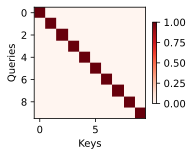

In [2]:
attention_weights = torch.eye(10).reshape((1,1,10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Attention Pooling ```Nadaraya-Watson Kernel Regression```

- Attention pooling은 결국 Query와 Key의 상호작용의 결과이다. 
- Attention pooling은 선택적으로 입력을 취합하여 출력을 생성한다. 


In [3]:
import torch
from torch import nn
from d2l import torch as d2l



### Generating the Dataset

- 예시를 위해 y_i = 2 * sin(x_i) + x_i ** 0.8 + e의 관계를 갖는 y와 x pair의 데이터셋을 생성


In [4]:
import torch

n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train

tensor([0.0597, 0.1096, 0.1531, 0.4476, 0.4762, 0.6516, 1.1385, 1.1670, 1.3369,
        1.3931, 1.4514, 1.6346, 1.6571, 1.6767, 1.7031, 1.7115, 2.0928, 2.1166,
        2.1423, 2.3508, 2.4586, 2.5889, 2.6530, 2.6718, 2.7264, 2.7960, 2.9491,
        2.9804, 2.9936, 3.1584, 3.2257, 3.2327, 3.5839, 3.5930, 3.6139, 3.6555,
        3.6726, 3.6770, 3.7615, 4.1812, 4.1821, 4.2801, 4.3137, 4.3298, 4.3388,
        4.3843, 4.4827, 4.5161, 4.7707, 4.9199])

In [5]:
def f(X: torch.Tensor):
    return 2 * torch.sin(X) + X**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, size=(n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
x_test, y_train

(tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
         1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
         2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
         3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
         4.5000, 4.6000, 4.7000, 4.8000, 4.9000]),
 tensor([0.2279, 0.0342, 1.0073, 1.3647, 1.6855, 2.0018, 3.6282, 3.4023, 2.3994,
         3.6867, 3.3804, 3.4057, 3.7408, 3.4102, 4.4866, 2.5528, 3.4056, 3.6284,
         3.1205, 2.8160, 2.7724, 2.7369, 4.0647, 2.6031, 3.4577, 2.4210, 2.4267,
         2.7703, 2.5255, 2.0393, 1.6676, 3.0050, 1.4988, 1.9908, 1.4322, 2.5136,
         1.7268, 1.5200, 1.8457, 1.3706, 1.2197, 1.6732, 0.9436, 1.5173, 1.9367,
         1.2534, 1.7729, 1.0053, 1.7173, 0.8144]))

### Average Pooling

- "dumbest estimator"
- 단순히 y_train의 모든 값에 대한 평균
- x_i에 대한 의존성 없음 (일직선)

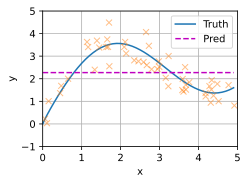

In [6]:
from d2l import torch as d2l
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], 
             xlim=[0,5], ylim=[-1,5])
    d2l.plt.plot(x_train, y_train, 'x', alpha=0.5)

y_hat =  torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### Nonparametric Attention Pooling

- Naradaya-Watson에 의해 제안된 방식은 Value (y_i)의 weight term (attention weight)에 Key(x_i)와 Query(x)의 kernel 함수에 의해 표현되는 Naradaya-Watson kernel regression이다. 
- 모든 key-value pair에 대해 유효한 (음수가 아니며 합치면 1이 되는..) 성질의 확률 분포를 갖는 weight를 얻을 수 있음. (softmax와 유사)
- Nadaraya-Watson attention pooling은 non-parameteric attention pooling의 대표적인 케이스
- 아래 예시는 test input이 query 그리고 train input이 key로 kernel 함수를 통해 weight를 얻음


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]]) /  tensor([0.0597, 0.1096, 0.1531, 0.4476, 0.4762, 0.6516, 1.1385, 1.1670, 1.3369,
        1.3931, 1.4514, 1.6346, 1.6571, 1.6767, 1.7031, 1.7115, 2.0928, 2.1166,
        2.1423, 2.3508, 2.4586, 2.5889, 2.6530, 2.6718, 2.7264, 2.7960, 2.9491,
        2.9804, 2.9936, 3.1584, 3.2257, 3.2327, 3.5839, 3.5930, 3.6139, 3.6555,
        3.6726, 3.6770, 3.7615, 4.1812, 4.1821, 4.2801, 4.3137, 4.3298, 4.3388,
        4.3843, 4.4827, 4.5161, 4.7707, 4.9199]) / tensor([[-0.0597, -0.1096, -0.1531,  ..., -4.5161, -4.7707, -4.9199],
        [ 0.0403, -0.0096, -0.0531,  ..., -4.4161, -4.6707, -4.8199],
        

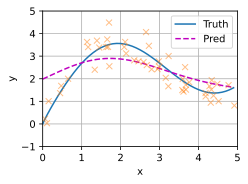

In [7]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2/2, dim=1)

y_hat = torch.matmul(attention_weights, y_train)
print(f'{X_repeat} /  {x_train} / {(X_repeat - x_train)} / {y_train} / {y_hat}')
plot_kernel_reg(y_hat)

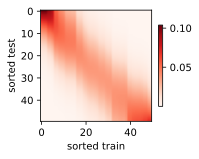

In [8]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='sorted train', ylabel='sorted test')


### Parametric Attention Pooling

- nonparametric N-W kernel regression은 충분한 데이터가 주어진다면 Optimal Solution으로 수렴할 수 있다는 일관성의 장점이 있으나
- 그럼에도 불구하고 learnable parameter를 추가하는 일이 그렇게 어려운 일이 아님

#### Batch Matrix Multiplication

- 각 minibatch에 대해 attention weight를 효과적으로 계산하기 위해 batch matrx multiplication이라는 것을 활용할 수 있다.


In [9]:
X = torch.ones((2,1,4))  ## n, input
Y = torch.ones((2,4,6)) ## n, output

torch.bmm(X,Y).shape


torch.Size([2, 1, 6])

In [10]:
weights = torch.ones((2,10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
weights.unsqueeze(1).shape, values.unsqueeze(-1).shape

(torch.Size([2, 1, 10]), torch.Size([2, 10, 1]))

#### Defining Model

- bmm를 이용하여 간단한 parametric N-W kernel regression을 구현


In [11]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
        
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        print(queries.shape)
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, 
                                                       dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
    
    
        

In [12]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))


keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
print(x_train.repeat((n_train,1)))
print(keys)
print(X_tile.shape)


tensor([[0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199],
        ...,
        [0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.5161, 4.7707, 4.9199]])
tensor([[0.1096, 0.1531, 0.4476,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1531, 0.4476,  ..., 4.5161, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.4476,  ..., 4.5161, 4.7707, 4.9199],
        ...,
        [0.0597, 0.1096, 0.1531,  ..., 4.4827, 4.7707, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.4827, 4.5161, 4.9199],
        [0.0597, 0.1096, 0.1531,  ..., 4.4827, 4.5161, 4.7707]])
torch.Size([50, 50])


epoch 30, loss 13.260629653930664


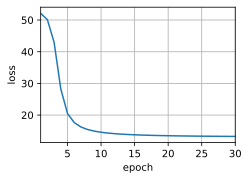

In [13]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.01)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1,30])

for epoch in range(30):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    animator.add(epoch + 1, float(l.sum()))
    print(f'epoch {epoch + 1}, loss {float(l.sum())}')

    

torch.Size([50, 50])


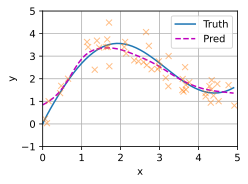

In [14]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

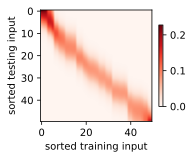

In [15]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='sorted training input',
                 ylabel='sorted testing input')

## Attention Scoring Function

- queies와 keys로 부터 weight를 얻기 위해 사용된 gaussian kernel을 적용해 왔다. softmax로 간소화 되기 이전 즉, exponent를 제외한 부분을 attention scoring function이라 함.
- 이 attention scoring function의 결과값은 softmax를 통과하여 각 keys에 대응되는 values의 확률 분포 (혹은 attention weight)가 되며...
- attention pooling의 최종 결과는 이 attention weight에 의한 values의 weighted sum이다. 
- attention weight가 확률 분포의 형태 (즉, 합이 1이 되는...)이므로 **결과적으로 attention pooling의 결과값은 weighted average라고 볼 수 있다.**
- 다양한 attention scoring function이 있을 수 있으며 당연히도 이에 따라 다른 특성을 보인다. 
- 이어서 널리 사용되는 2가지 scoring function을 살펴 볼것임

### Masked Softmax Operation

- 앞서 masked crossentropy와 유사하게 모든 입력이 유효한 정보를 갖는 것이 아님 (<pad> 등...)
- 따라서 attention scoring function의 결과 값에 대해서도 이 유효 구간에 대해서만 적용이 되도록 할 필요가 있음
    
    
    



In [16]:
#@save 
def masked_softmax(X: torch.Tensor, valid_lens: torch.Tensor):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [17]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4753, 0.5247, 0.0000, 0.0000],
         [0.4769, 0.5231, 0.0000, 0.0000]],

        [[0.3177, 0.3340, 0.3484, 0.0000],
         [0.2613, 0.2604, 0.4783, 0.0000]]])

### Additive Attention

- q와 k가 서로 다른 dim.을 가지고 있더라도..
- 각각을 적절히 선택된 fc를 통해 병합이 가능한 같은 dim으로 만들 수 있다.
- 이렇게 병합된 출력에 tanh의 activation을 적용하여 additive attention을 구현


In [18]:
#@save 
class AdditiveAttention(nn.Module):
    
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        # Query (batch, # of queries, query vector)
        # key (batch, # of key, key vector)
        # values (batch, feature)
        
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries (batch, # of queries, num_hidden)
        # key (batch, # of key, key_vector)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print(f'shape of query: {queries.shape} => {queries.unsqueeze(2).shape}' + 
              f' / shape of query: {keys.shape} => {keys.unsqueeze(1).shape}')
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        print(f'features {features.shape} / scores {scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        return torch.bmm(self.dropout(self.attention_weights), values)

In [19]:
queries, keys = torch.normal(0,1,(2,2,20)), torch.ones((2,10,2))

values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

shape of query: torch.Size([2, 2, 8]) => torch.Size([2, 2, 1, 8]) / shape of query: torch.Size([2, 10, 8]) => torch.Size([2, 1, 10, 8])
features torch.Size([2, 2, 10, 8]) / scores torch.Size([2, 2, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

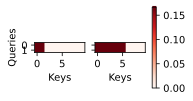

In [20]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,2,2,10)), xlabel='Keys', ylabel='Queries')

### Scaled Dot-Product Attention

- 연산 효율을 최적화하기 위한 한 가지 방법은 Scoring function으로 단순히 dot-product를 사용하는 것
- 단, vector의 길이가 같아야 한다는 제약이 있는데...
- 만약 두 vector (query and key)가 zero mean을 갖는 random proc.이면
- 이에 대한 dot product은 역시 zero mean을 갖는다.
- 게다가 variance를 강제로 1로 맞춰 주기 위해 scale factor인 sqrt(d)로 나눠 주게된다. 여기서 d는 vector의 size임.

#### Note
> Additive attention과 달리 **자체적으로는 learnable parameters가 없는 것처럼 보이는데**, 일반적으로 이 scaled dot-product attention의 **query, key, value 입력단에 linear layer가 존재**한다. d2l-en version에서 다소 이상하게 보일 수 있는 부분인데, 뒤에서 multi-head attention 부분에서 parameterization cost 측면에서 additive attention 대비 장점이 있다라고 설명된 부분은 이러한 측면에서 linear layer를 포함하고 보느냐 아니냐에 따라 크게 달라질 수 있는 부분으로 보임. 관련 참고[[1]](https://ai.stackexchange.com/questions/20176/what-is-the-intuition-behind-the-dot-product-attention)[[2]](http://peterbloem.nl/blog/transformers)



In [21]:
import math
#@save
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        print(f'{scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
    

In [22]:
queries = torch.normal(0, 1, (2,1,2))
print(f'{queries.shape} {keys.shape}')
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 2]) torch.Size([2, 10, 2])
torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

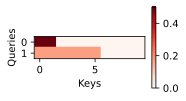

In [23]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)), xlabel='Keys', ylabel='Queries')

## Bahdanau Attention

- 기존 Seq. to Seq. 구조에서 encoder는 fixed shape의 context variable을 생성하고 decoder는 이 context variable과 token 입력을 통해 다음 token output을 생성하였다.
- 모든 입력 token 입력의 중요도가 같지 않음에도 항상 같은 fixed context variable을 decoder의 입력으로 사용해왔다.
- 즉, 새로운 시도에서는 
  - 매 token 생성 시 연관성에 따라 입력 token의 업데이트 된 중요도를 반영한 context variable이 생성될 수 있게...
  - 입력 token의 길이가 길어졌을 때 고정된 context variable이라는 제약으로 정확도가 떨어지는 문제가 생기지 않게...
- 이러한 Idea에 착안하여 Bahdanau 등은  alignment 제약이 없는 미분가능한 attention model을 고안하였다. 
- 이를 통해 token을 생성(예측)할 때 모든 입력 토큰을 사용하는 것이 아닌 현재 생성과 연관된 토큰만을 사용하는 attention model
  - decoder의 hidden state(query)와 encoder의 hidden state를 (key,values)로 하는 additive attention  

### Model

- decoder의 hidden state(query)와 encoder의 hidden state를 (key,values)로 하는 additive attention  


In [24]:
import torch
from torch import nn
from d2l import torch as d2l



### Decoder with Attention

- Bahdanau attention의 RNN encoder-decoder에서 decoder만 바뀌게 됨.



In [25]:
#@save 
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError
        

- Decode의 상태는 아래 3가지로 초기화
  
  - encoder의 final layer hidden state at all steps (outputs)
  - encoder의 all layer의 hidden state at final step (hidden state of encoder)
  - the encoder valid length (enc_valid_lens)
- 매 decode step 마다...
  - Attention의 입력은..
    - query로 이전 step의 decoder hidden state의 final layer를 사용
    - encoder의 final layer hidden state at all steps를 key & valuse로 사용
    - 이 attention의 출력이 context variable이 됨
  - 이전 step의 embedding과 context variable (attention의 output)을 concat하여 encoder의 입력으로..

In [26]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, 
                                     enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights
    
            
        

In [27]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 8324.1 tokens/sec on cuda:0


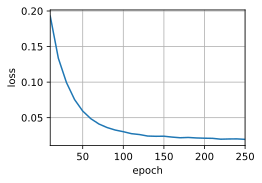

In [28]:
embed_size, num_hiddens, num_layers, dropout = 32,32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [29]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, 
                                                                eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


## Multi-Head Attention

- Main idea 
  - 주어진 query, key, value에 대해 다양한 attention mechanism을 적용함으로써 sequence의 short-range vs. long-range 의존성 등 key, query, value 간의 subspace representation을 파악하는데 유용성이 있을 것이라는 착안

### Model

- Q,K,V를 다수의 attention (주로 scaled dot-product)에 병렬로 넣어주고 각 attention의 output을 concat & FC로 merge하는 단계를 거치는 구조

### Implementation

- attention unit은 scaled dot-product attention을 사용한다. 연산 효율을 높이고 parameterization cost를 줄일 수 있다 (라고 되어 있지만...결국 이는 linear layer를 포함하는 구조이며 이것이 scaled dot-product attention의 choice에 의존성이 있으므로, 일반적인 사실로 받아들이기는 어렵다.)

In [30]:
import math
import torch
from torch import nn
from d2l import torch as d2l


In [31]:
#@save 
def transpose_qkv(X: torch.Tensor, num_heads: int):
    # X : (B,(Q,K or V), num_hidden)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # X : (B,(Q,K or V), num_heads, num_hidden / num_heads)
    X = X.permute(0, 2, 1, 3)
    # X : (B, num_heads, (Q,K or V), num_hidden / num_heads)
    
    X = X.reshape(-1, X.shape[2], X.shape[3])
    # X : (B * num_heads, (Q,K or V), num_hidden / num_heads)
    return X

#@save
def transpose_output(X: torch.Tensor, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    X = X.reshape(X.shape[0], X.shape[1], -1)
    return X

    
    

#@save 
class MultiHeadAttention(nn.Module):
    
    def __init__(self, k_size, q_size, v_size, num_hiddens, 
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(q_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(k_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(v_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, 
                values: torch.Tensor, valid_lens: torch.Tensor):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, 
                                                 repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
    
        

In [32]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()


MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [33]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## Self-Attention and Positional Encoding

- deep learning에서 seq. encoding에 CNN 혹은 RNN을 자주 사용한다...
- attention을 이러한 용도로 사용한다는 생각...
- 동일한 token의 seq.를 attention의 query, key, value로 사용하여 output을 encoding으로써 사용...
- Q,K,V에 같은 입력을 사용하기 때문에 Self-Attention 혹은 Intra-Attention이라고 부름
- multi-head attention을 아래와 같이 사용해서 self-attention을 구할 수 있음


In [34]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                  num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [35]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### CNNs, RNNs vs. Self-Attention

- Computational complexity
- Sequential operations
- Max. path length

||CNN|RNN|Self-Attention|
|:-|:-:|:-:|:-:|
|Complexity|O(knd^2)|O(nd^2)|O(n^2d)|
|Seq operation|O(1)|O(n)|O(1)|
|Max. path length|O(n/k)|O(n)|O(1)|


### 참고
> 이하 내용은 Transformer가 최초로 소개 된 ```Attention is all you need``` 논문의 주요 내용 즉, Transformer 구현의 측면에서 각 요소들을 다룸. 갑자기 새로운 요소가 등장하는 것 같은 부분은 이러한 맥락에서 이해하면 됨.


### Positional Encoding

- RNN의 순차성 한계를 넘어..

> RNN에서 개별 token을 순차적, 재귀적으로 처리했다면, self-attention은 positional encoding을 이용해 순차적 정보를 다룸으로써 병렬로 처리할 수 있도록 함



#### Positional encoding 

- sequence R(d,v)로 d는 sequence의 step, v는 해당 token의 embedding index라고 했을 때, d가 even일 경우 sin odd일 경우 cos 함수로 (why?)
  - p_i,2j = sin(i / 10000^(2j/d))
  - p_i,2j+1 = cos(i / 10000^(2j/d))
- 따라서 같은 embedding index (즉, 같은 token)이라 하더라도 column (sequence 내 위치에 따라서) 값이 달라지게 되며..역도 성립함.
- 단, 주기적 성질을 가지고 있어 서로 다른 Token이 같은 값을 가지게 될 수 있음 
- Absolute Poisitional Information
  - d, v 공간의 고유한 위치를 표시함으로써 절대적인 공간적 위치를 제공할 뿐 아니라...
- Relative Positional Information
  - 인접 값들간의 변화가 연속적이기 때문에, 주어진 offset만큼 vector 공간에 떨어져 있는 값에 대한 예측이 용이함



In [ ]:
#@save



## Transformer

- CNN 및 RNN 대비 Attention은 연산 효율성 측면에서 많은 장점이 있다. (낮은 순차적 의존성 / 짧은 최대 경로 / 낮은 연산 복잡도)
- 따라서 RNN 및 CNN을 완전히 대체하는 시도들을 함. 
- 17년 Attention is All you need라는 논문을 통해서 Seq2Seq 문제에서 이러한 성과를 보여줬으며...
- 이후 보다 광범위한 분야의 ML 연구에 활용되기 시작
- 여기서는 주로 17년도 Attention is All you need라는 논문의 내용을 위주로 다루게됨

- 주요 요소

  - Positional Encoding
  - Positionwise Feed-Forward Network
  - Layer Normalization
  - Residual Connection
  - Multi-Head Self Attention

### Encoder

- 아래와 같이 상대적으로 간결한 구조가 반복되는 Deep Network을 구성한다.

>  Positional Encoding -> Multi-Head Self Attention -> AddNorm -> Positionwise Feed-Forward Network로 구성

### Decoder 

- Encoder의 Output을 Decoder에 입력으로 받기 위한 Attention Layer가 있으며 이 Encoder의 Output (Context Variable)이 K,V로 Decoder의 이전 Step 출력이 Q로 입력된다. 역시 이러한 구조를 반복하여 Deep Network을 구성

> Positional Encoding -> Masked Multi-Head Self Attention -> AddNorm -> Multi-Head Attention (Endcoder-Decoder Attention) -> AddNorm -> Positionwise Feed-Forward Network -> AddNorm -> FC 

### Positionwise Feed-Forward Networks

- (Batch,Steps,Embed)와 같은 형태의 X에 대해 각 Step에 대응되는 즉,Embed Vector에 대응되는 임의 크기의 Vector를 생성하는 MLP임. 

### Residual Connection and Layer Noramlization

- Residual Connection 즉, 앞단의 출력 (즉, 현재의 입력을) 현재의 출력에 Add하는 부분이 존재하며 이에 대한 장단점은 ResNet에서와 같은 의미를 가진다.
- Layer Normalization이 추가적으로 수행되는데, Batch Norm과 비슷하나 Batch는 Cross Batch의 Normalization을 Layer Normalization은 Batch 내의 Element간에 수행된다. 


  